# PlasticParcels DRAKKAR Tutorial
In this tutorial we will introduce you to some of the basic Parcels functions, as well as utilise the PlasticParcels tool for simulating microplastic pollution in the Mediterranean sea.

By the end of this tutorial you should be able to create and visual hydrodynamic (and other) fields, create particle sets that represent marine microplastic pollution release locations, and apply physics parameterisations to simulate the dispersal of microplastics in the ocean.

In [2]:
## Library imports
import os

from utils import select_files, create_directory, getclosest_ij
from helper import create_fieldset, create_particleset, create_kernel, load_default_settings, load_test_settings

from parcels import ParticleFile
#from plotting import plot_release_locations
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np

In [3]:
# ## User options
# testing_version = 'local'
# if testing_version == 'local':
#     user_settings = {'user': 'denes001',
#                     'output_directory': '../../data/output_data/',
#                     'fig_directory': '../../fig/',
#                     }
# else:
#     user_settings = {'user': 'denes001',
#                     'output_directory': '/storage/shared/oceanparcels/output_data/data_Michael/PlasticTransportKernels/data/output_data/',
#                     'fig_directory': '/storage/shared/oceanparcels/output_data/data_Michael/PlasticTransportKernels/fig/',
#                     }

# ## Create directories if missing
# create_directory(user_settings['output_directory'])
# create_directory(user_settings['fig_directory'])

# Model settings
Using PlasticParcels, we will load the default settings for our sumulations, using the `load_default_settings` function.

This returns two dictionary of parameters, one used for fieldset creation, the other for particleset creation.

You can update the parameters by updating the dictionaries as necessary.

The description of each parameter can be found in the PlasticParcels/helper.py file.

In [10]:
## Load the default model and particle settings
model_settings, particle_settings = load_test_settings() #load_default_settings()

In [11]:
## View settings
model_settings

{'input_data_dir': '../../data/input_data/',
 'input_data_dir_2': '../../data/input_data/',
 'input_data_dir_3': '../../data/input_data/',
 'mode': '3D',
 'ocean_dir': 'MOi/psy4v3r1/',
 'ocean_filename': 'psy4v3r1-daily_',
 'ocean_mesh': 'MOi/domain_ORCA0083-N006/coordinates.nc',
 'bathymetry_mesh': 'MOi/domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc',
 'mixing_f': True,
 'biofouling_f': True,
 'bgc_dir': 'MOi/biomer4v2r1/',
 'bgc_filename': 'biomer4v2r1-weekly_',
 'bgc_mesh': 'MOi/domain_ORCA025-N006/mesh_hgr_PSY4V3_deg.nc',
 'bgc_biofilm_density': 1388.0,
 'bgc_algae_cell_volume': 2e-16,
 'bgc_boltzmann_constant': 1.3805834190672156e-23,
 'bgc_respiration_rate': 1.1574074074074074e-06,
 'bgc_respiration_temperature_coefficient': 2.13,
 'bgc_shear_frequency': 2.0,
 'bgc_carbon_atomic_weight': 12.0,
 'bgc_collision_probability': 1.0,
 'bgc_algae_mortality_rate': 1.0,
 'bgc_algae_respiration_f': 1.0,
 'stokes_f': True,
 'stokes_dir': 'ERA5/waves/',
 'stokes_filename': 'ERA5_global_waves

In [5]:
## Update settings

#model_settings['mode'] = '2D'
#model_settings['mixing_f'] = False
#model_settings['biofouling_f'] = False
#model_settings['stokes_f'] = False
#model_settings['wind_f'] = False



# Create a Parcels fieldset
We now create the fieldset that contains all the required fields (ocean velocities, temperature and salinity, ocean biology, winds and waves, etc.).

We loaded the default settings above, which we will pass into the `create_fieldset` PlasticParcels function. This removes a lot of the complexity when creating fieldsets with a large number of underlying fields. What is produced is a Parcels fieldset object.

In [55]:
fieldset = create_fieldset(model_settings, particle_settings)

print("Time origin of data: ", fieldset.time_origin)

Time origin of data:  2019-01-09T12:00:00.000000000


To list all the fields that are present we use `.get_fields()` method to return a list of the fields, which we can then utilise and analyse.

In [33]:
for parcels_field in fieldset.get_fields():
    print(parcels_field.name)

U
V
W
conservative_temperature
absolute_salinity
UV
UVW
bathymetry
mixing_kz
pp_phyto
bio_nanophy
bio_diatom
Stokes_U
Stokes_V
wave_Tp
Wind_U
Wind_V
unbeach_U
unbeach_V


## Plotting Parcels `fields`
Parcels fields are not loaded into memory straight away, they are (Deferred load something?).

To visualise these fields we can load in the first timestep of data.

We do this using the `.computeTimeChunk(time, dt)` method, which takes as input a model time to load, and a number of timesteps to load.

Once loaded, we plot the resulting fields using the `pcolormesh` matplotlib function. Below is a small snippet of code used to plot these fields.


Better way to highlight below
!! 

<div class="alert alert-info">
Note - the plots below aren't ~exactly~ the velocity fields loaded, since the plotting assumes plotting at T-points (or an A-grid) and we've loaded a C-grid

</div>

### Note that a number of these fields use different grids (e.g. 1/12th degree C-Grid for ocean velocities, 1/4th degree A-grid for wind/waves, 1/4th degree C-grid for biology), and Parcels handles all of that in the background

In [57]:
## Load data into memory
fieldset.computeTimeChunk(0,1)

21600

In [16]:
## Plotting function
def plot_field(lons, lats, data, title):
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    colors = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    plt.title(title)
    plt.colorbar(colors)
    plt.show()


Note that some fields have no depth component (e.g. bathymetry, wind, waves), and so the shape of their data is different.

In [60]:
print("The usual shape order is (time, depth, latitude, longitude)")
print("Ocean U velocity data shape:", fieldset.U.data.shape)
print("Ocean V velocity data shape:", fieldset.V.data.shape)
print("Wind U velocity data shape:", fieldset.Wind_U.data.shape)
print("Wind V velocity data shape:", fieldset.Wind_U.data.shape)
print("Bathymetry shape:", fieldset.bathymetry.data.shape)

The usual shape order is (time, depth, latitude, longitude)
Ocean U velocity data shape: (2, 50, 503, 489)
Ocean V velocity data shape: (2, 50, 503, 489)
Wind U velocity data shape: (2, 721, 1450)
Wind V velocity data shape: (2, 721, 1450)
Bathymetry shape: (1, 3059, 4322)


Plot the ocean surface velocity fields

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


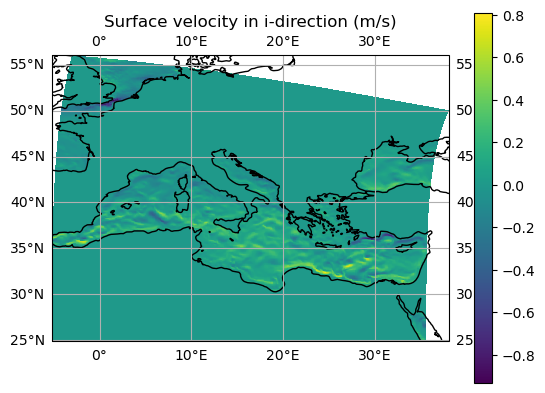

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


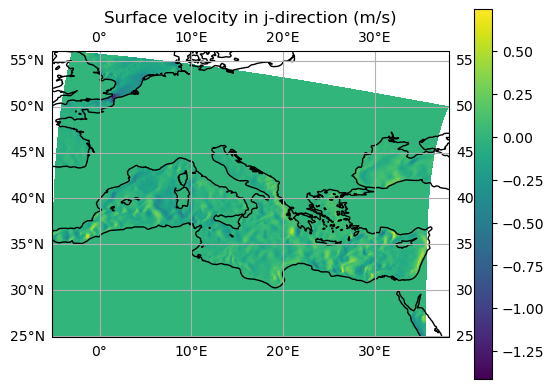

In [76]:
## Plot velocity fields
plot_field(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,0], "Surface velocity in i-direction (m/s)")
plot_field(fieldset.V.grid.lon, fieldset.V.grid.lat, fieldset.V.data[0,0], "Surface velocity in j-direction (m/s)")

Plot the model bathymetry field

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


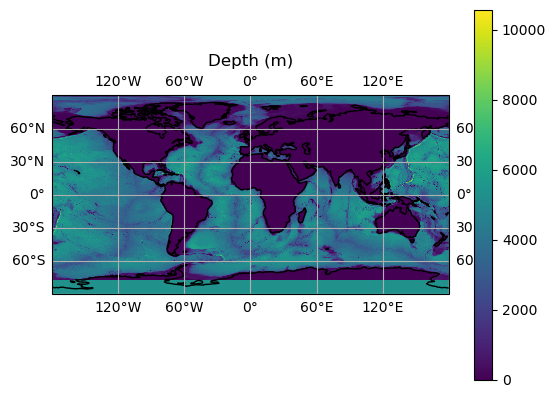

In [35]:
## Plot bathymetry
plot_field(fieldset.bathymetry.grid.lon, fieldset.bathymetry.grid.lat, fieldset.bathymetry.data[0], "Depth (m)")

Plot the 10m-wind velocity fields

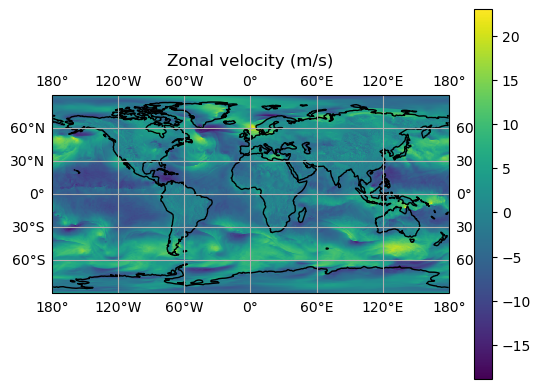

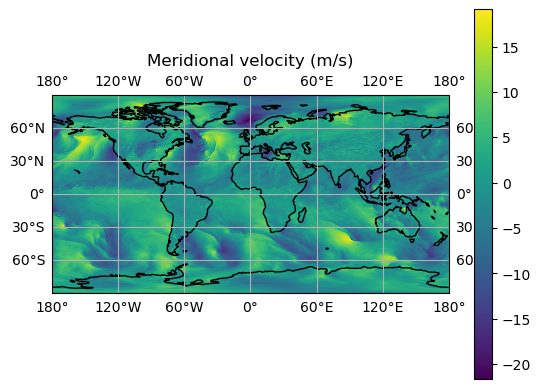

In [52]:
## Plot Wind velocity fields
plot_field(fieldset.Wind_U.grid.lon, fieldset.Wind_U.grid.lat, fieldset.Wind_U.data[0], "Zonal wind velocity (m/s)")
plot_field(fieldset.Wind_V.grid.lon, fieldset.Wind_V.grid.lat, fieldset.Wind_V.data[0], "Meridional wind velocity (m/s)")

Plot vertical eddy diffusivity

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


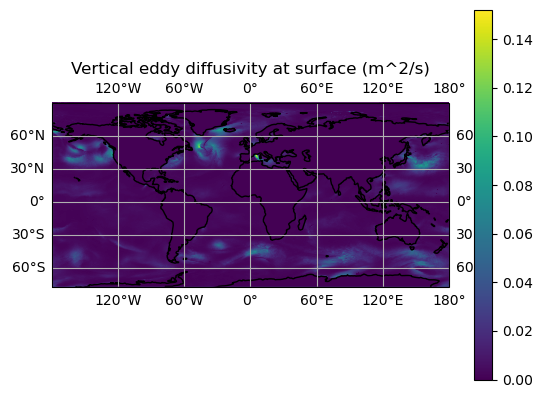

In [62]:
## Plot Vertical Diffusivity field
plot_field(fieldset.mixing_kz.grid.lon, fieldset.mixing_kz.grid.lat, fieldset.mixing_kz.data[0,0], "Vertical eddy diffusivity at surface (m^2/s)")

Plot biology related fields

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


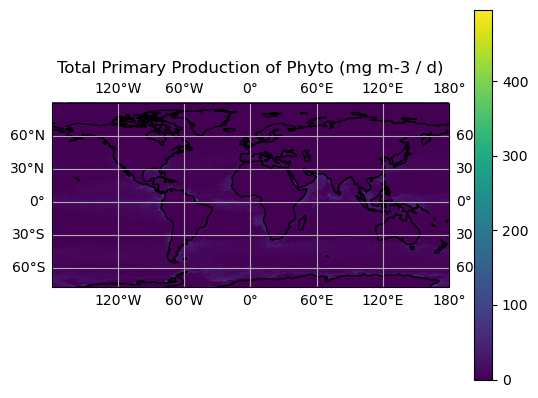

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


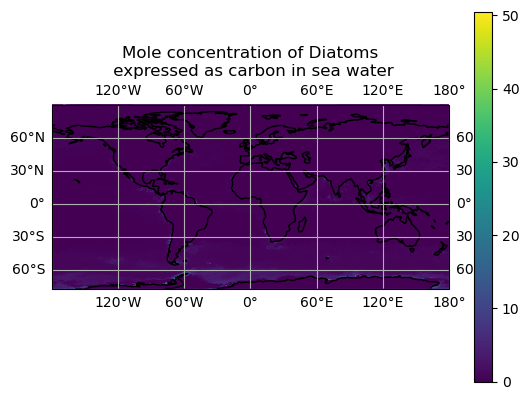

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


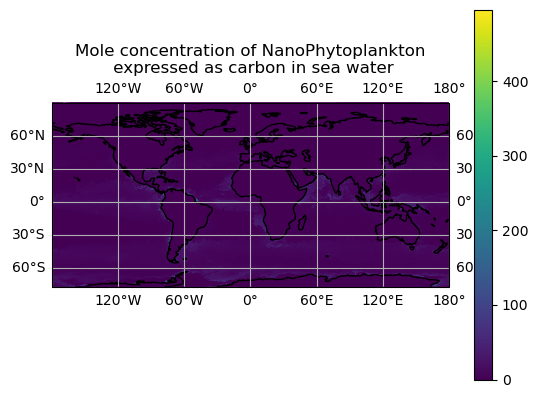

In [64]:
## Plot pp_phyto
plot_field(fieldset.pp_phyto.grid.lon, fieldset.pp_phyto.grid.lat, fieldset.pp_phyto.data[0,0], "Total Primary Production of Phyto (mg m-3 / d)")
plot_field(fieldset.bio_diatom.grid.lon, fieldset.bio_diatom.grid.lat, fieldset.bio_diatom.data[0,0], "Mole concentration of Diatoms\n expressed as carbon in sea water")
plot_field(fieldset.pp_phyto.grid.lon, fieldset.pp_phyto.grid.lat, fieldset.pp_phyto.data[0,0], "Mole concentration of nanophytoplankton\n expressed as carbon in sea water")

# Parcels can also be used as a standalone field interpolator
There are two ways to access the data in each Parcels field object. Firstly, as above, accessing the data directly and using the grid indices directly.

Another way to access the field data is to pass the field a (time, depth, latitude, longitude) tuple, from which Parcels will interpolate the data for you.

It's important to note that ... (!!i/j vs. rotated notes)



In [79]:
# Sample the U,V ocean velocities at the ocean surface somewhere in the Mediterranean
poi = [35.25, 20.11] # Point of Interest: 35.25deg North, 20.11deg East

U_value = fieldset.U[0,0,poi[0],poi[1]]
V_value = fieldset.V[0,0,poi[0],poi[1]]
print("Surface velocities in the i-, j-directions:", U_value, V_value)

U_value, V_value = fieldset.UV[0,0,poi[0],poi[1]]
print("Surface velocities in the zonal-, meridional-directions:", U_value, V_value)

## degrees/sec - highlight from https://docs.oceanparcels.org/en/latest/examples/tutorial_unitconverters.html

Surface velocities in the i-, j-directions: 1.1433753050420808e-06 2.699197438271291e-07
Surface velocities in the zonal-, meridional-directions: 1.2040195495488277e-06 2.0662101712086765e-07


In [80]:
## Determine the ocean depth at some point in the Mediterranean
print(fieldset.bathymetry[0,0,poi[0], poi[1]])

3000.6534811816796


# Particle Sets
We will now create some particle sets. In the first instance we will create a basic particle set using Parcels. In the second instance we will use the PlasticParcels tool to create more complicated particle sets that replicate likely microplastic release locations.

## Creating a simple particle set
Parcels includes a number of methods to create particle sets.

The most commonly used is `ParticleSet.from_list()`, which allows you to pass through a list of longitudes, latitudes, depths, and times.

In [98]:
## Randomly place particle release locations on a grid
n_particles = 25
lons = np.random.uniform(2,7,n_particles)
lats = np.random.uniform(35,40,n_particles)

# Randomly place the particles between the ocean surface and 50m depth
depths = np.random.uniform(0,50, n_particles)


#times = np.linspace(0,50000,n_particles)

release_locations = {'lons': lons,
                     'lats': lats,
                     'depths': depths,
}

# Other settings
wind_test = np.random.uniform(0,0.05,n_particles)
density_test = np.random.uniform(1000,1050,n_particles)
diameter_test = np.random.uniform(0.00001, 0.01, n_particles)
## Particleset settings
particle_settings.update({'release_locations': release_locations, # A dictionary of lons, lats, depths (optional), and times (optional)
                          'windage_coefficient': wind_test, # A float or Nx1 array of windage coefficients, values in [0,1] [percent of wind speed]
                          'particle_density': density_test, # A float or Nx1 array of particle densities [kg m-3]
                          'particle_diameter': diameter_test, # A float or Nx1 array of particle lengths [m]
                          'write_output_option': 'none' # Option to write variables. Options: 'none' (default), 'tracer' (saves tracer fields), 'dynamic' (saves all variables that change spatiotemporally), 'all' (saves all variables)
                           })
pset = create_particleset(fieldset, particle_settings)
kernels = create_kernel(fieldset, pset)

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


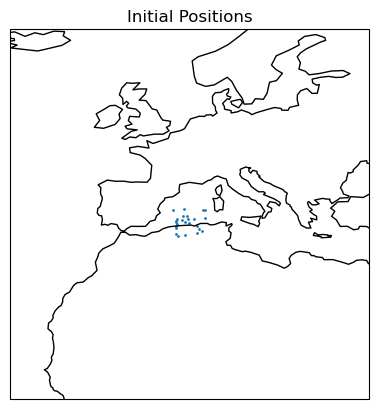

In [99]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, s=1, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
plt.title("Initial Positions")
plt.show()

In [30]:
kernels

[<function kernels.PolyTEOS10_bsq(particle, fieldset, time)>,
 <function parcels.application_kernels.advection.AdvectionRK4_3D(particle, fieldset, time)>,
 <function kernels.biofouling(particle, fieldset, time)>,
 <function kernels.Stokes_drift(particle, fieldset, time)>,
 <function kernels.windage_drift(particle, fieldset, time)>,
 <function kernels.vertical_mixing(particle, fieldset, time)>,
 <function kernels.unbeaching(particle, fieldset, time)>,
 <function kernels.checkThroughBathymetry(particle, fieldset, time)>,
 <function kernels.checkErrorThroughSurface(particle, fieldset, time)>,
 <function kernels.periodicBC(particle, fieldset, time)>,
 <function kernels.deleteParticle(particle, fieldset, time)>]

In [31]:
#kernels.pop(3) # Remove stokes drift, I think it kicks the particle into land and then interpolation gets funky
#kernels.pop(2) # Remove biofouling to see if that is the cause of nans

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


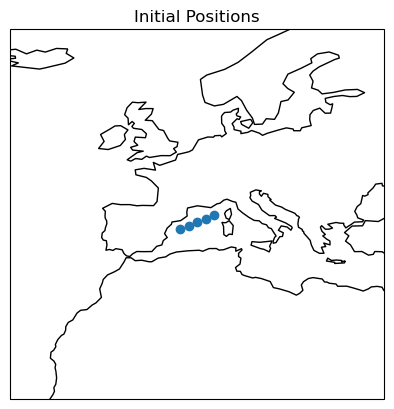

INFO: Output files are stored in ../../data/output_data/trajectory/PolyTEOS10_bsq|AdvectionRK4_3D|biofouling|Stokes_drift|windage_drift|vertical_mixing|unbeaching|checkThroughBathymetry|checkErrorThroughSurface|periodicBC|deleteParticle.zarr.
100%|██████████| 259200.0/259200.0 [01:24<00:00, 3072.35it/s]


/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


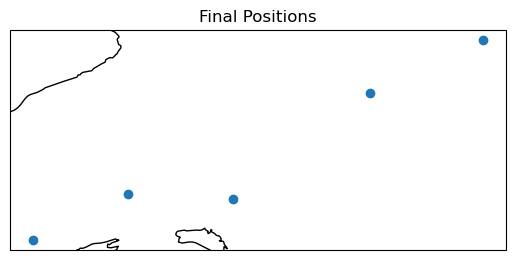

____________________ 
 Success with PolyTEOS10_bsq|AdvectionRK4_3D|biofouling|Stokes_drift|windage_drift|vertical_mixing|unbeaching|checkThroughBathymetry|checkErrorThroughSurface|periodicBC|deleteParticle
 ____________________


In [32]:

kernel_name = '|'.join([kernel.__name__ for kernel in kernels])
# Plot locations
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
plt.title("Initial Positions")
plt.show()

pfile = ParticleFile(user_settings['output_directory']+'trajectory/'+kernel_name+'.zarr', pset, outputdt=particle_settings['dt_write'])
pset.execute(kernels, runtime=particle_settings['runtime'], dt=particle_settings['dt_timestep'], output_file=pfile)


#Plot locations final
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
ax.coastlines()
#ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
plt.title("Final Positions")
plt.show()
print("____________________ \n Success with", kernel_name +'\n ____________________')


In [33]:
pset

P[5](lon=2.318457, lat=39.957264, depth=0.500000, time=258000.000000)
P[6](lon=3.310598, lat=40.435351, depth=1.439195, time=258000.000000)
P[7](lon=4.399362, lat=40.383431, depth=0.500000, time=258000.000000)
P[8](lon=5.811394, lat=41.481568, depth=2578.559814, time=258000.000000)
P[9](lon=6.992524, lat=42.030305, depth=2713.879150, time=258000.000000)

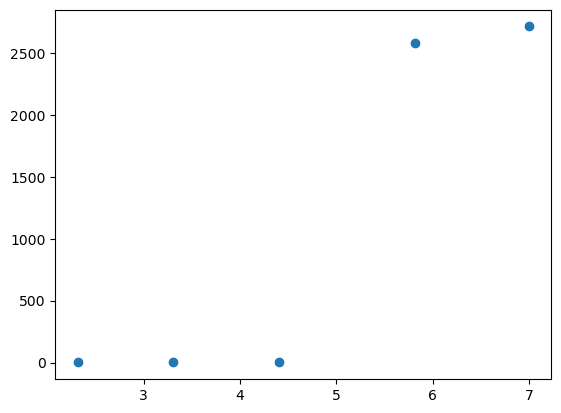

In [34]:
plt.scatter(pset.lon, pset.depth)
plt.show()

In [35]:
kernel_name

'PolyTEOS10_bsq|AdvectionRK4_3D|biofouling|Stokes_drift|windage_drift|vertical_mixing|unbeaching|checkThroughBathymetry|checkErrorThroughSurface|periodicBC|deleteParticle'

In [36]:
import xarray as xr

In [37]:
pset_df = xr.open_dataset(user_settings['output_directory']+'trajectory/'+kernel_name+'.zarr')

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [38]:
pset_df['z'].data

array([[3.50519413e+01, 5.00000000e-01, 5.00000000e-01],
       [1.48224736e+01, 5.00000000e-01, 2.75236692e+01],
       [2.96485285e+01, 5.00000000e-01, 5.00000000e-01],
       [4.84714266e+00, 2.56791235e+03, 2.57326562e+03],
       [1.92522376e+01, 2.71387915e+03, 2.71387915e+03]])

## Creating a plastic release particle set

# Particleset settings
TODO: Write description here -- user must define particle release locations

In [ ]:


## Show particle release locations
#plot_release_locations(release_locations)

# Kernel creation
This should be pretty simple based on the flags above

In [ ]:
len_kernels = len(kernels)

In [ ]:
[kernels[0]]

In [ ]:
kernels

In [ ]:
for i in range(len_kernels-3):
    #Reset the particle set and kernels
    pset = create_particleset(fieldset, particle_settings)
    kernels = create_kernel(fieldset, pset)
    
    # Plot locations
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
    plt.title("Initial")
    plt.show()


    test_kernel=kernels[i]
    kernels = [test_kernel, kernels[-3], kernels[-2], kernels[-1]]
    try:
        print("____________________ \n Testing with", test_kernel.__name__ +'\n ____________________')
        pfile = ParticleFile(user_settings['output_directory']+'trajectory/'+test_kernel.__name__+'.zarr', pset, outputdt=particle_settings['dt_write'])
        pset.execute(kernels, runtime=particle_settings['runtime'], dt=particle_settings['dt_timestep'], output_file=pfile)
        

        #Plot locations final
        fig = plt.figure()
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
        plt.title("Final")
        plt.show()
        print("____________________ \n Success with", test_kernel.__name__ +'\n ____________________')

    except Exception as error:
        print("Error with", test_kernel.__name__)
        print(error)

In [ ]:
0.004176*0.5

In [ ]:

# for test_kernel in kernels:
#     pfile = ParticleFile(user_settings['output_directory']+test_kernel.__name__+'.zarr', pset, outputdt=particle_settings['dt_write'])
#     pset.execute(test_kernel, runtime=particle_settings['runtime'], dt=particle_settings['dt_timestep'], output_file=pfile)
kernels

In [ ]:
# Test with all particles
pset = create_particleset(fieldset, particle_settings)
kernels = create_kernel(fieldset, pset)
#kernels.remove(kernels[0])
#kernels.remove(kernels[4])
#kernels.remove(kernels[3])
kernel_name = '|'.join([kernel.__name__ for kernel in kernels])
# Plot locations
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
plt.title("Initial")
plt.show()

pfile = ParticleFile(user_settings['output_directory']+'trajectory/'+kernel_name+'.zarr', pset, outputdt=particle_settings['dt_write'])
pset.execute(kernels, runtime=particle_settings['runtime'], dt=particle_settings['dt_timestep'], output_file=pfile)


#Plot locations final
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree())
ax.coastlines()
#ax.set_extent([np.min(pset.lon)-25, np.max(pset.lon)+25, np.min(pset.lat)-25, np.max(pset.lat)+25])
plt.title("Final")
plt.show()
print("____________________ \n Success with", kernel_name +'\n ____________________')


In [ ]:
## having some issues with stokes and wind without unbeaching
kernels

In [ ]:
fieldset = create_fieldset(model_settings, particle_settings)
pset = create_particleset(fieldset, particle_settings)
kernels = create_kernel(fieldset, pset)
fieldset.computeTimeChunk(0,1)

In [ ]:
particle = pset[-1]
stokes_U = fieldset.Stokes_U[0, particle.depth, particle.lat, particle.lon]
stokes_V = fieldset.Stokes_V[0, particle.depth, particle.lat, particle.lon]
T_p = fieldset.wave_Tp[0, particle.depth, particle.lat, particle.lon]

wind_U = fieldset.Wind_U[0, particle.depth, particle.lat, particle.lon]
wind_V = fieldset.Wind_V[0, particle.depth, particle.lat, particle.lon]

In [ ]:
T_p

In [ ]:
import math
omega_p = 2. * math.pi / T_p
        
# Peak wave number
k_p = (omega_p ** 2) / fieldset.G

# Repeated inner term of Eq. (19) - note depth is negative in this formulation, but model depths are positive by convention
kp_z_2 = 2. * k_p * particle.depth

# Decay factor in Eq. (19) -- Where beta=1 for the Phillips spectrum
decay = math.exp(-kp_z_2) - math.sqrt(math.pi * kp_z_2) * math.erfc(math.sqrt(kp_z_2))

In [ ]:
particle_dlon = stokes_U * decay * 60*5
particle_dlat = stokes_V * decay * 60*5

In [ ]:
particle_dlat, particle_dlon

In [ ]:
if particle.depth < 0.5*particle.particle_diameter:
    print('Moving')
    # Compute particle displacement
    particle_dlon += particle.windage_coefficient * wind_U * particle.dt
    particle_dlat += particle.windage_coefficient * wind_V * particle.dt

In [ ]:
particle_dlat, particle_dlon

In [ ]:
fieldset.Stokes_U[0, particle.depth, particle.lat, particle.lon], fieldset.Stokes_U[0, 0, particle.lat, particle.lon]